### Importing basic libraries

In [2]:
import PyPDF2
import pandas as pd
import re

## Import pdf

In this section, I will be reading pages 5 to 26 of the "deposit account agreement" pdf I obtained from Chase Bank's website. The rest of the pages in the PDF are irrelevant.

I will create a pandas dataframe "extracted_text_df" and add each page as a row into this.

In [2]:
#function to extract text from pdf
def extract_text_from_pdf(pdf_path, start_page, end_page):
    with open(pdf_path, 'rb') as file:
        pdf_reader = PyPDF2.PdfReader(file)
        
        # Validate the page range
        if end_page > len(pdf_reader.pages) or start_page < 1:
            print("Invalid page range.")
            return None

        # Initialize an empty list to store page content
        page_contents = []

        # Extract text from specified pages
        for page_number in range(start_page - 1, end_page):
            page = pdf_reader.pages[page_number]
            page_contents.append(page.extract_text())

    # Create a DataFrame with page numbers and content
    df = pd.DataFrame({'Page': range(start_page, end_page + 1), 'Content': page_contents})

    return df

In [3]:
# variables to call the function
pdf_path = 'deposit-account-agreement.pdf'
start_page = 5
end_page = 26

#call function and save in df
extracted_text_df = extract_text_from_pdf(pdf_path, start_page, end_page)

In [4]:
# Display the DataFrame
print(extracted_text_df)

    Page                                            Content
0      5  DEPOSIT ACCOUNT AGREEMENT\nJPMorgan Chase Bank...
1      6  DEPOSIT ACCOUNT AGREEMENT\nJPMorgan Chase Bank...
2      7  DEPOSIT ACCOUNT AGREEMENT\nJPMorgan Chase Bank...
3      8  DEPOSIT ACCOUNT AGREEMENT\nJPMorgan Chase Bank...
4      9  DEPOSIT ACCOUNT AGREEMENT\nJPMorgan Chase Bank...
5     10  DEPOSIT ACCOUNT AGREEMENT\nJPMorgan Chase Bank...
6     11  DEPOSIT ACCOUNT AGREEMENT\nJPMorgan Chase Bank...
7     12  DEPOSIT ACCOUNT AGREEMENT\nJPMorgan Chase Bank...
8     13  DEPOSIT ACCOUNT AGREEMENT\nJPMorgan Chase Bank...
9     14  DEPOSIT ACCOUNT AGREEMENT\nJPMorgan Chase Bank...
10    15  DEPOSIT ACCOUNT AGREEMENT\nJPMorgan Chase Bank...
11    16  DEPOSIT ACCOUNT AGREEMENT\nJPMorgan Chase Bank...
12    17  DEPOSIT ACCOUNT AGREEMENT\nJPMorgan Chase Bank...
13    18  DEPOSIT ACCOUNT AGREEMENT\nJPMorgan Chase Bank...
14    19  DEPOSIT ACCOUNT AGREEMENT\nJPMorgan Chase Bank...
15    20  DEPOSIT ACCOUNT AGREEMENT\nJPM

## Change data to right format
Dealing with PDFs is never easy! The information from the pdf file has many formatting issues in it. Plus, we need to clean the text as well. Here's a few things we will be taking care of in this section:

1. Remove punctuations and special characters
2. Split file into paragraphs
3. Remove stopwords and lemmatize

To get started, let's see how the data of one page looks.

In [5]:
# Access and display the content, formatted using print
formatted_content = extracted_text_df.iloc[0].Content
print(formatted_content)


DEPOSIT ACCOUNT AGREEMENT
JPMorgan Chase Bank, N.A. Member FDIC© 2023 JPMorgan Chase & Co.Page 5 of 26
Effective 10/15/2023Deposit Account Agreement
This agreement is the contract that governs your account.
Whether you have a personal or business deposit account, this document is the basic agreement between you and us (JPMorgan Chase Bank, N.A. or “Chase”). By 
signing a signature card or submitting an account application, or by using any of our deposit account services, you and anyone else identiﬁed as an owner of the account agree to the terms in this agreement. Customers of some of our business groups, such as Corporate Banking, will get a different agreement and their accounts will be governed by that agreement, not this one. If you have a product that is not a deposit account, such as a credit card, this agreement does not apply to that product. Also, other products or services, such as online banking or retirement accounts, may have additional agreements. In the event of an irrec

#### function to fix lines
A lot of the formatting is not how we want it. One thing I noticed is that, every new paragraph starts with a header that does not have a punctuation. So, if our aim is to get paragraphs from this big formatted file, we can combine all lines that end with a punctuation into one paragraph.

In the function below, we remove the new line character of any line that is preceeded by a punctuation (? ! : .)

In [6]:

def FixLines(original_content):
    # Remove new line characters not preceded by a punctuation
    formatted_content = re.sub(r'(?<=[?!:.])\n', ' ', original_content)
    return formatted_content



In [7]:
# Applying it to dataframe
extracted_text_df['Formatted_content'] = extracted_text_df['Content'].apply(FixLines)

In [8]:
#Taking a look at one page now
x=extracted_text_df.iloc[4].Formatted_content
print(x)

DEPOSIT ACCOUNT AGREEMENT
JPMorgan Chase Bank, N.A. Member FDIC© 2023 JPMorgan Chase & Co.Page 9 of 26
Effective 10/15/2023 -There are some instances where we do not have the time of the transaction therefore we post at the end of the day the transaction occurred: • We are unable to show the transaction as pending; or
• We don’t receive an authorization request from the merchant but the transaction is presented for payment. • Third, there are some transactions that we cannot process automatically or until we’ve completed posting of your chronological transactions. This includes 
Overdraft Protection transfers or transfers to maintain target balances in other accounts. We subtract these remaining transactions in high to low dollar order. • Finally, fees are assessed last. If you review your account during the day, you will see that we show some transactions as “pending.” For details, refer to the section “Pending” transactions . These 
transactions impact your available balance, but hav

Our new column "Formatted_content" contains the formatted text. We can now remove the precious column.

In [9]:
#Remove precious column
extracted_text_df=extracted_text_df.drop('Content',axis=1)

In [10]:
extracted_text_df.head()

,Page,Formatted_content
0,5,DEPOSIT ACCOUNT AGREEMENT\nJPMorgan Chase Bank...
1,6,DEPOSIT ACCOUNT AGREEMENT\nJPMorgan Chase Bank...
2,7,DEPOSIT ACCOUNT AGREEMENT\nJPMorgan Chase Bank...
3,8,DEPOSIT ACCOUNT AGREEMENT\nJPMorgan Chase Bank...
4,9,DEPOSIT ACCOUNT AGREEMENT\nJPMorgan Chase Bank...


Next up, we split the pages into paragraphs. The goal is to have a dataframe where each row has the following information:
1. Page Number
2. A single paragraph from that page

In [11]:
import pandas as pd



# Function to split content into paragraphs
def split_into_paragraphs(page, content):
    paragraphs = content.split('\n')  # Assuming paragraphs are separated by single line breaks
    rows = []

    for i, paragraph in enumerate(paragraphs):
        #not appending first two paragraphs as they contain generic bank details
        if i==0 or i==1:
            continue
        else:
            rows.append({'Page': page, 'Formatted_content': paragraph})

    return rows

# Create a list to store the paragraphs
paragraphs_list = []

# Apply the function to each row in the original DataFrame
for index, row in extracted_text_df.iterrows():
    page = row['Page']
    content = row['Formatted_content']
    paragraphs_list.extend(split_into_paragraphs(page, content))

# Create a new DataFrame from the list of paragraphs
paragraphs_df = pd.DataFrame(paragraphs_list)

# Display the new DataFrame with one paragraph per row
print(paragraphs_df)


     Page                                  Formatted_content
0       5      Effective 10/15/2023Deposit Account Agreement
1       5  This agreement is the contract that governs yo...
2       5  signing a signature card or submitting an acco...
3       5  fees, and (4) other disclosures, agreements, a...
4       5  Here are some important terms that we use thro...
..    ...                                                ...
479    26  will reimburse you for any fees you paid to th...
480    26  federal judicial district that includes your a...
481    26  JPMorgan Chase Bank, N.A. Member FDIC© 2023 JP...
482    26                               Effective 10/15/2023
483    26                        Return to Table of Contents

[484 rows x 2 columns]


Let's look at how the new dataframe, "paragraphs_df" turned out.

In [12]:
paragraphs_df.head()

,Page,Formatted_content
0,5,Effective 10/15/2023Deposit Account Agreement
1,5,This agreement is the contract that governs yo...
2,5,signing a signature card or submitting an acco...
3,5,"fees, and (4) other disclosures, agreements, a..."
4,5,Here are some important terms that we use thro...


In [13]:
paragraphs_df[paragraphs_df.Page==6].Formatted_content

24    Effective 10/15/2023If your joint account beco...
25    activity that caused the overdraft. If one joi...
26    will refuse to pay all transactions, including...
27    owners, including adding another owner to the ...
28    account to a court or government agency if we ...
29    If a joint account has rights of survivorship,...
30    If a joint account does not have rights of sur...
31    Except as otherwise stated in this paragraph, ...
32    bene ﬁciary only upon the death of the last su...
33    If one owner of a marital account dies, the su...
34    account contains a payable on death designatio...
35    determine the respective interests of the owne...
36    A Florida joint account owned solely by two sp...
37    If you establish your account payable on death...
38    the account to the bene ﬁciary or bene ﬁciarie...
39    not offer POD accounts in all states. 4. “In t...
40    If you establish your account as in trust for ...
41    an “ITF” account. If we receive proof you’

Next, we will remove stopwords and lemmatize the text.

In [14]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [15]:
# initialize stopwords and lemmatizer function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [16]:
#function to lemmatize and remove stop words
def preprocess_text(text):
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.lower() not in stop_words]
    return ' '.join(filtered_tokens)

In [17]:
#call function
paragraphs_df['Processed_content'] = paragraphs_df['Formatted_content'].apply(preprocess_text)


Let's see how the new column with the changes made, "Processed_content" looks

In [18]:
paragraphs_df.head()

,Page,Formatted_content,Processed_content
0,5,Effective 10/15/2023Deposit Account Agreement,Effective 10/15/2023Deposit Account Agreement
1,5,This agreement is the contract that governs yo...,agreement contract governs account . Whether p...
2,5,signing a signature card or submitting an acco...,signing signature card submitting account appl...
3,5,"fees, and (4) other disclosures, agreements, a...","fee , ( 4 ) disclosure , agreement , amendment..."
4,5,Here are some important terms that we use thro...,important term use throughout agreement : Acco...


We will be using this column for keyword extraction

## Testing Different Keyword Search Methods
Here, I will be trying out two ways to get keywords.

### 1. Using summa
The first method I want to try is from a library called summa.

In [19]:
from summa import keywords

In [20]:
TR_keywords = keywords.keywords(paragraphs_df.iloc[8].Processed_content, scores=True)
print(TR_keywords[0:10])

[('pending debit transaction', 0.46784205481019764), ('deposit', 0.46784205481019703)]


In [21]:
paragraphs_df.iloc[30].Processed_content

'joint account right survivorship , one joint owner dy , owner ’ interest pass owner ’ estate . Either surviving joint owner deceased owner ’ estate may withdraw fund time , responsibility determining respective interest owner . account designated “ Tenants common ” “ JTIC , ” right survivorship . survivorship right apply'

I don't like these results very much, but I will still keep it here in case it will be useful for future project expansion

### 2. keybert 
We will now try using the library "keybert", which uses a machine learning model to extract keywords. The best part of this is method is that I can change the parameters of the model to best suit my purpose!


In [23]:
from keybert import KeyBERT

In [ ]:
kw_model = KeyBERT(model='all-mpnet-base-v2')

In [ ]:
keywords = kw_model.extract_keywords(paragraphs_df.iloc[30].Processed_content, 

                                     keyphrase_ngram_range=(1, 3), 

                                     stop_words='english', 

                                     highlight=False,

                                     top_n=10)

keywords_list= list(dict(keywords).keys())

print(keywords_list)

This model works great! Looks like we will be using this one.

## Keyword extraction using keybert
Now that we have picked the methodology, let's go ahead and extract keywords from our paragraphs.


In [ ]:
#function to extract keywords
def getKeywordsOfDocument(s):
    keywords = kw_model.extract_keywords(s, 

                                     keyphrase_ngram_range=(1, 3), 

                                     stop_words='english', 

                                     highlight=False,

                                     top_n=10)

    keywords_list= list(dict(keywords).keys())
    return keywords_list
    

In [40]:
#calling function, and creating new column to store keywords
paragraphs_df['keywords'] = paragraphs_df['Processed_content'].apply(getKeywordsOfDocument)

NameError: name 'getKeywordsOfDocument' is not defined

Let's take a look at the new "keywords" column added to the dataframe. We will be using this column for our EDA, and to match intent to keywords in the "chatbot functions" file.

In [ ]:
paragraphs_df.head()

In [ ]:
paragraphs_df.to_csv("paragraphs.csv")

### Visualization on keywords

Some common EDA on text are wordclouds and topic analysis. 

In [25]:
# Use if loading the file again
paragraphs_df = pd.read_csv("paragraphs.csv")

In [26]:
# Use if loading the file again
paragraphs_df = paragraphs_df.drop('Unnamed: 0', axis=1)

In [27]:
# Use if loading the file again
paragraphs_df.head()

,Page,Formatted_content,Processed_content,keywords
0,5,Effective 10/15/2023Deposit Account Agreement,Effective 10/15/2023Deposit Account Agreement,"['2023deposit account agreement', 'account agr..."
1,5,This agreement is the contract that governs yo...,agreement contract governs account . Whether p...,"['agreement jpmorgan chase', 'basic agreement ..."
2,5,signing a signature card or submitting an acco...,signing signature card submitting account appl...,"['agreement applicable chase', 'chase agreemen..."
3,5,"fees, and (4) other disclosures, agreements, a...","fee , ( 4 ) disclosure , agreement , amendment...","['fee apply account', 'fee disclosure agreemen..."
4,5,Here are some important terms that we use thro...,important term use throughout agreement : Acco...,"['account covered agreement', 'agreement accou..."


First up, creating a wordcloud!

In [6]:
from wordcloud import WordCloud

In [7]:
import matplotlib.pyplot as plt

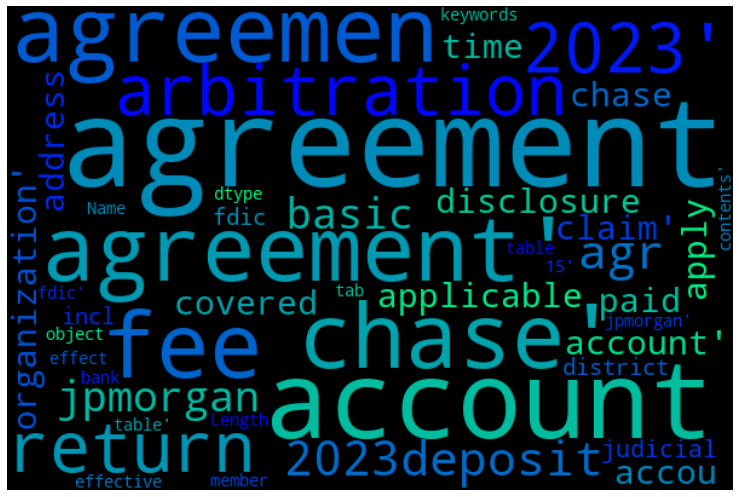

In [8]:
cloud=WordCloud(colormap="winter",width=600,height=400).generate(str(paragraphs_df['keywords']))
fig=plt.figure(figsize=(13,18))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')

The wordcloud shows what the document is about, which is mainly Chase, Deposit, Agreement and JP Morgan. Sounds about right! It also shows 2023, because this agreement was for the year 2023. some other big words were arbitration, claim and return.

### Topic Modelling of keywords

Next step is topic modelling, this will show us all the main topics in the document. 

In [15]:
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.colors as mcolors

In case you are loading the datafile again just for the EDA bit, use the function below to convert "keywords" column from string back to a list!! 

In [28]:
#string to list
#only if you loaded the file again
def str_to_list(s):
    s=s[1:-1]
    l=s.split(',')
    return l

In [29]:
#calling function
#only if you loaded file again
paragraphs_df['keywords']=paragraphs_df['keywords'].apply(str_to_list)

Now, let's get started on our topic analysis. First up, we will create a word matrix out of the keywords used.

In [31]:
dictionary = corpora.Dictionary(paragraphs_df['keywords'])
doc_term_matrix = [dictionary.doc2bow(rev) for rev in paragraphs_df['keywords']]

Next, we call the LDA model with the matrix. I specified the number of topics I want as 4.

In [36]:
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=4, random_state=100,
                chunksize=200, passes=100)

Let's take a look at the topics formed.

In [37]:
lda_model.print_topics()

[(0,
  '0.005*" \'return table\'" + 0.005*" \'chase com\'" + 0.005*" \'table\'" + 0.005*" \'table contents\'" + 0.004*" \'chase mobile\'" + 0.004*" \'return\'" + 0.004*" \'contents\'" + 0.004*" \'deposit\'" + 0.003*" \'com chase mobile\'" + 0.003*" \'return table contents\'"'),
 (1,
  '0.003*" \'check\'" + 0.003*" \'stop payment\'" + 0.002*" \'account\'" + 0.002*" \'early withdrawal penalty\'" + 0.002*" \'account statement\'" + 0.002*" \'cd owner\'" + 0.002*" \'fund transfer\'" + 0.001*" \'substitute check\'" + 0.001*" \'funds transfer service\'" + 0.001*" \'withdrawal penalty\'"'),
 (2,
  '0.004*" \'effective 10\'" + 0.003*" \'effective 10 15\'" + 0.003*" \'transaction\'" + 0.002*" \'debit card\'" + 0.002*" \'direct deposit\'" + 0.002*" \'deposit\'" + 0.002*" \'term agreement\'" + 0.002*" \'behalf\'" + 0.002*" \'account bearing\'" + 0.002*" \'payment network\'"'),
 (3,
  '0.004*" \'fdic\'" + 0.004*" \'arbitration\'" + 0.004*" \'arbitration claims\'" + 0.003*" \'party arbitration\'" + 

This looks hard to understand. I'm going to plot it to make it more visually appealing.

In [38]:
#defining colors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

#definings wordcloud, which will be called for each topic
cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

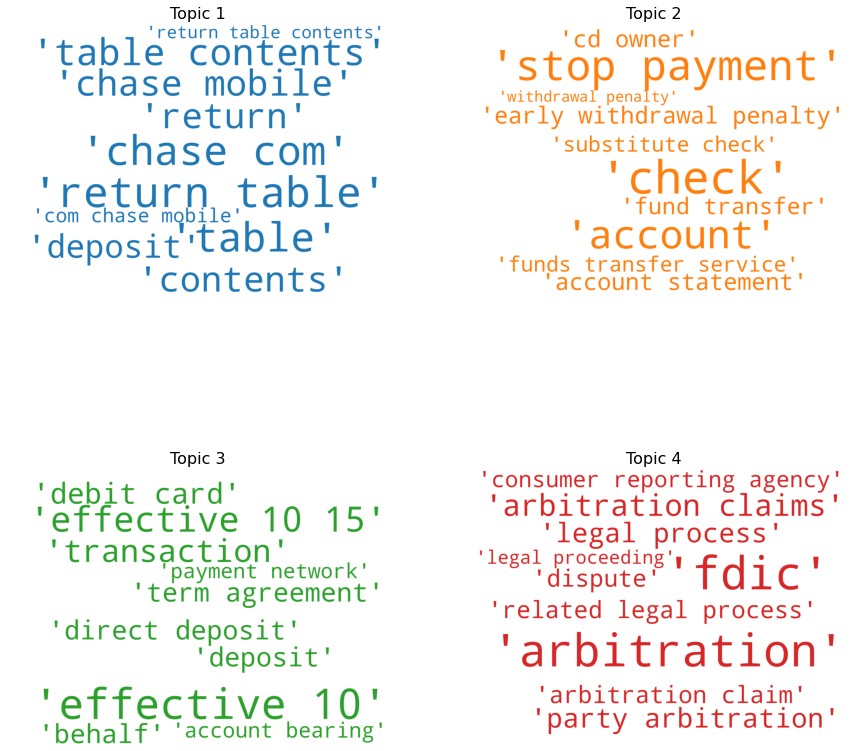

In [39]:
#get topics
topics = lda_model.show_topics(formatted=False)

#create a plot
fig, axes = plt.subplots(2, 2, figsize=(15,15), sharex=True, sharey=True)

#add topics to plot
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')

Better!

The four main topics in this document seem to be 
1. "Chase bank" 
2. "account, payments, checks and transfers" 
3. "deposit and transaction
4. "legal matters"

It's good to know what the data is about before asking the chatbot questions about the data!